In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
df=pd.read_excel('train(1).xlsx')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [3]:
df.shape


(16209, 21)

In [4]:
df.drop(['id'],axis=1, inplace=True)

In [5]:
df['date']=pd.to_datetime(df['date'])
df['year']=df['date'].apply(lambda x: x.year)
df['month']=df['date'].apply(lambda x: x.month)
df.drop(['date'], axis=1,inplace=True)

In [6]:
df['zipcode'].nunique()

70

In [7]:
le=LabelEncoder()
le.fit(df['zipcode'])
df['zipcode']=le.transform(df['zipcode'])

In [8]:
df['yr_renovated'].value_counts()

yr_renovated
0       15537
2014       68
2005       31
2003       27
2000       27
        ...  
1934        1
1951        1
1948        1
1954        1
1956        1
Name: count, Length: 69, dtype: int64

In [9]:
df['renovated']=df['yr_renovated'].apply(lambda x: 0 if x==0 else 1)
df.drop(['yr_renovated'], axis=1,inplace=True)

In [10]:
cor=df.corr()['price'].sort_values(ascending=False).drop(['price', 'zipcode'])

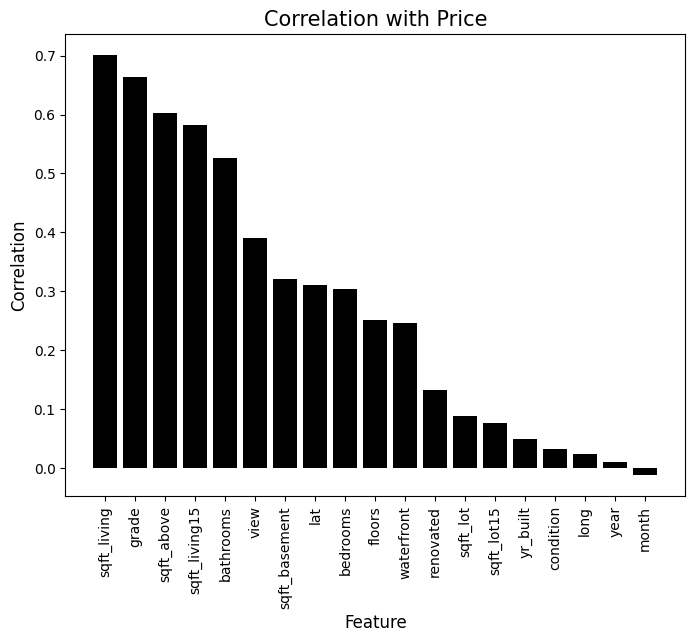

In [208]:
plt.figure(figsize=(8,6))
plt.bar(x=list(cor.index), height=list(cor.values), color='black')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation with Price', fontsize=15)
plt.show()

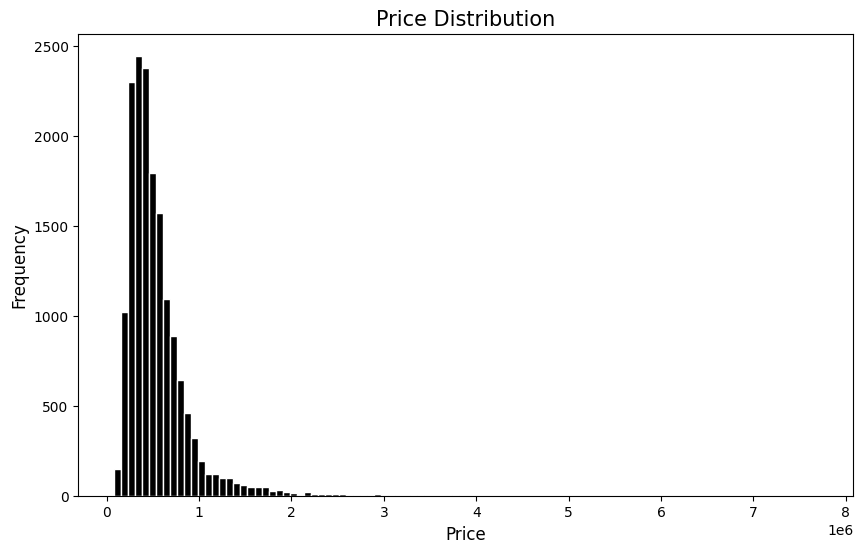

In [206]:
plt.figure(figsize=(10,6))
plt.hist(x='price', bins=100, data=df, edgecolor='w',color='black')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

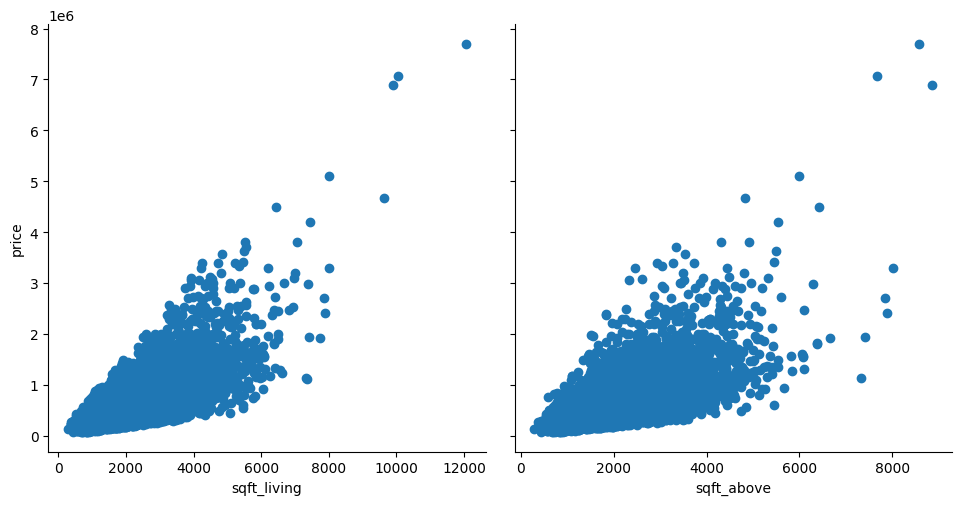

In [209]:
new=sns.PairGrid(df,x_vars=['sqft_living', 'sqft_above'], y_vars=['price'],height=5,aspect=1)
new.map(plt.scatter)
plt.show()

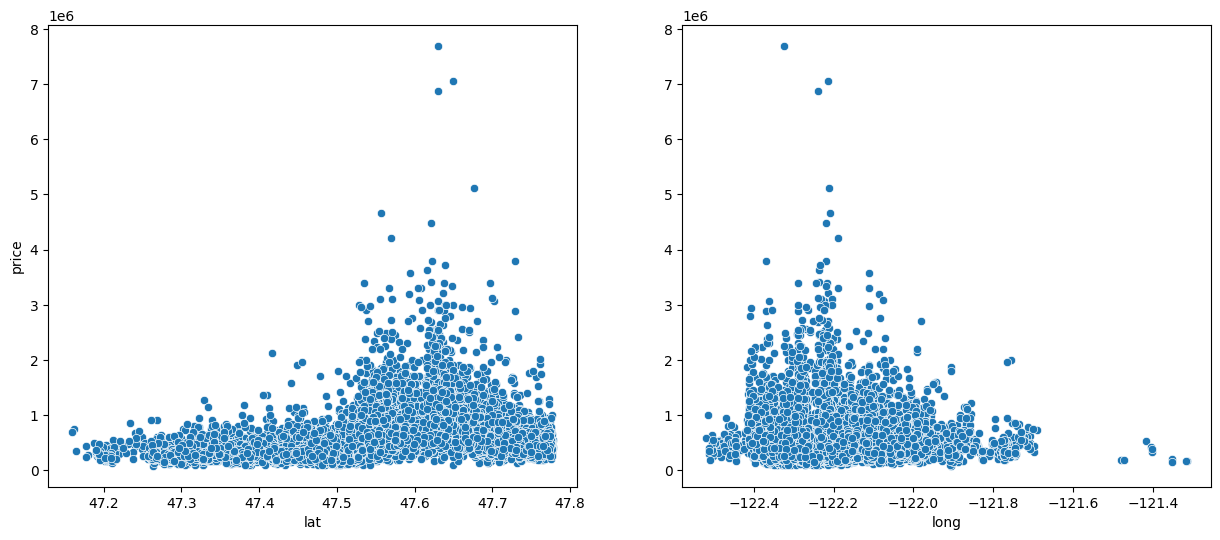

In [210]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot( x='lat',y='price', data=df)
plt.subplot(1,2,2)
sns.scatterplot( x='long',y='price', data=df)
plt.ylabel('')
plt.show()

In [12]:
# Define the PyTorch model
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 19)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(19, 19)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(19, 19)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(19, 19)
        self.relu4 = nn.ReLU()
        self.output_layer = nn.Linear(19, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.output_layer(x)
        return x

In [15]:
X=df.drop(['price'],axis=1).values
y=df['price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)


In [16]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [17]:
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Scale target variable (y_train and y_test)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [18]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model_pytorch = HousePriceModel(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

# Training loop
epochs = 250
batch_size = 128

# Lists to store loss history
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_pytorch.train() # Set model to training mode
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad() # Zero the gradients
        outputs = model_pytorch(batch_X) # Forward pass
        loss = criterion(outputs, batch_y) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Evaluate on training data
    model_pytorch.eval() # Set model to evaluation mode
    with torch.no_grad():
        train_output = model_pytorch(X_train_tensor)
        train_loss = criterion(train_output, y_train_tensor).item()
        train_losses.append(train_loss)

        # Evaluate on validation data
        val_output = model_pytorch(X_test_tensor)
        val_loss = criterion(val_output, y_test_tensor).item()
        val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [10/250], Train Loss: 0.0005, Validation Loss: 0.0006
Epoch [20/250], Train Loss: 0.0004, Validation Loss: 0.0005
Epoch [30/250], Train Loss: 0.0004, Validation Loss: 0.0004
Epoch [40/250], Train Loss: 0.0003, Validation Loss: 0.0004
Epoch [50/250], Train Loss: 0.0003, Validation Loss: 0.0004
Epoch [60/250], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [70/250], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [80/250], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [90/250], Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [100/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [110/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [120/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [130/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [140/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [150/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [160/250], Train Loss: 0.0002, Validation Loss: 0.0003
Epoch [170/250], Train Loss: 0.00

In [19]:
loss_df = pd.DataFrame({'Train Loss': train_losses, 'Validation Loss': val_losses})

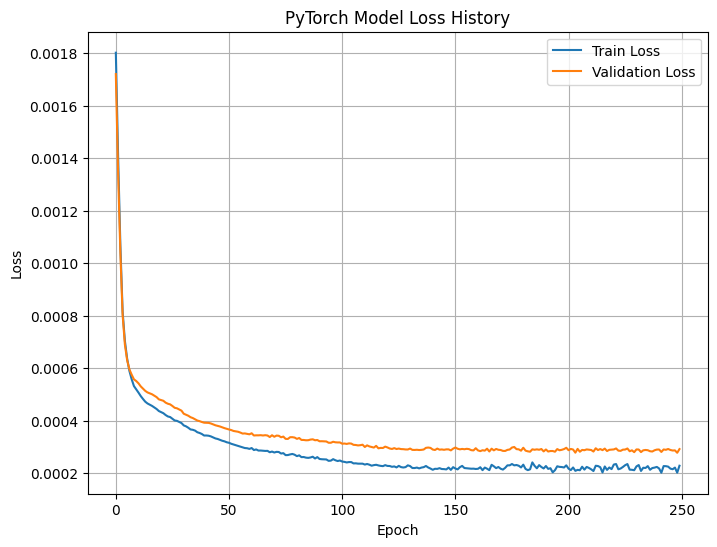

In [20]:
loss_df.plot(figsize=(8, 6))
plt.title('PyTorch Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [21]:
model_pytorch.eval()
with torch.no_grad():
    predictions_scaled = model_pytorch(X_test_tensor)
    # Inverse transform predictions to original scale
    predictions = scaler_y.inverse_transform(predictions_scaled.numpy())

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
exp_var = explained_variance_score(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Explained Variance Score: {exp_var}")
print(f"R2 Score: {r2}")

RMSE: 130014.45630390491
MAE: 77332.859375
Explained Variance Score: 0.8709380626678467
R2 Score: 0.8646866679191589


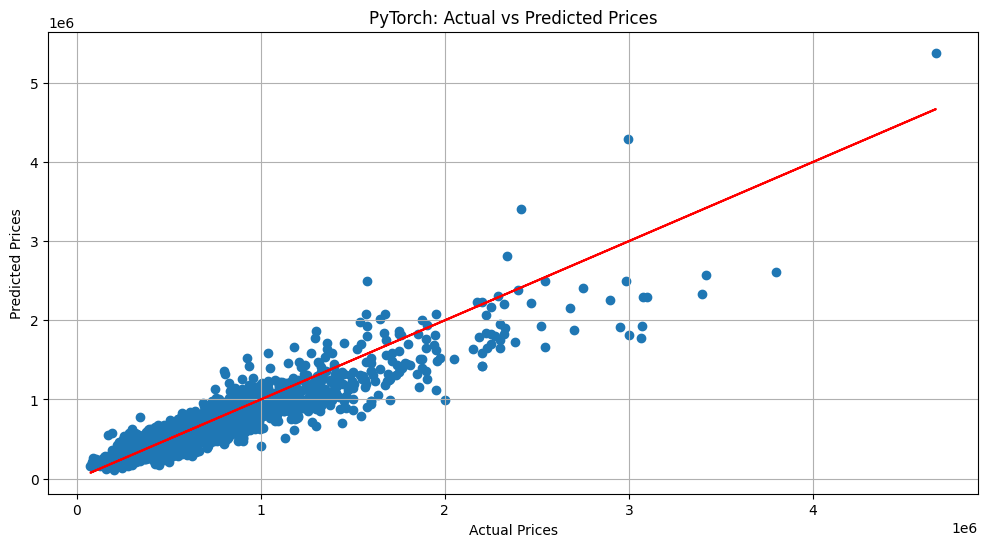

In [55]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,"r")
plt.title('PyTorch: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

In [89]:
single_house = df.drop("price",axis=1).iloc[1]

In [90]:
single_house

bedrooms            3.0000
bathrooms           2.5000
sqft_living      1600.0000
sqft_lot         2788.0000
floors              2.0000
waterfront          0.0000
view                0.0000
condition           4.0000
grade               7.0000
sqft_above       1600.0000
sqft_basement       0.0000
yr_built         1992.0000
zipcode            19.0000
lat                47.4034
long             -122.1870
sqft_living15    1720.0000
sqft_lot15       3605.0000
year             2014.0000
month               7.0000
renovated           0.0000
Name: 1, dtype: float64

In [91]:
import torch

# Assuming single_house is a DataFrame or Series with 17 features
# Step 1: Convert to numpy 2D array
single_house_np = single_house.values.reshape(1, -1)  # shape (1, 17)

# Step 2: Scale using trained MinMaxScaler
single_house_scaled = scaler_X.transform(single_house_np)

# Step 3: Convert to PyTorch tensor
single_house_tensor = torch.tensor(single_house_scaled, dtype=torch.float32)


In [92]:
single_house_scaled

array([[0.3       , 0.3125    , 0.11139456, 0.00211233, 0.4       ,
        0.        , 0.        , 0.75      , 0.5       , 0.15285881,
        0.        , 0.8       , 0.27536232, 0.38945994, 0.27574751,
        0.22732748, 0.00680524, 0.        , 0.54545455, 0.        ]])

In [93]:
model_pytorch.eval()
with torch.no_grad():
    y_pred_scaled = model_pytorch(single_house_tensor)

# Inverse transform to original price scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy().reshape(-1, 1))
print("Predicted price:", y_pred.item())


Predicted price: 257122.0625


In [94]:
df.head(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,renovated
0,268643,4,2.25,1810,9240,2.0,0,0,3,7,...,0,1961,30,47.4362,-122.187,1660,9240,2015,5,0
1,245000,3,2.50,1600,2788,2.0,0,0,4,7,...,0,1992,19,47.4034,-122.187,1720,3605,2014,7,0


In [195]:
# Feature order used during training
feature_order = df.drop(['price'], axis=1).columns
print("Training feature order:")
print(feature_order)


Training feature order:
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year', 'month', 'renovated'],
      dtype='object')


In [196]:
import pandas as pd
import torch

new_df = pd.read_excel('test2.xlsx')


In [197]:
if 'id' in new_df.columns:
    new_df.drop(['id'], axis=1, inplace=True)
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['year'] = new_df['date'].dt.year
new_df['month'] = new_df['date'].dt.month
new_df.drop(['date'], axis=1, inplace=True)
new_df['zipcode'] = le.transform(new_df['zipcode'])
new_df['renovated'] = new_df['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)
new_df.drop(['yr_renovated'], axis=1, inplace=True)



In [198]:
# Add any missing columns (safety)
for col in feature_order:
    if col not in new_df.columns:
        new_df[col] = 0

new_df = new_df[feature_order]

print("Final new_df shape:", new_df.shape)


Final new_df shape: (5404, 20)


In [199]:
new_df.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,renovated
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,32,47.4388,-122.162,2390,7700,2014,10,0
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,49,47.6784,-122.285,2370,6283,2014,8,0
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,5,47.5646,-122.129,3710,9685,2014,8,0
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,22,47.6995,-122.228,4050,14226,2015,3,0
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,28,47.6647,-122.083,2250,4050,2014,7,0


In [200]:
house=new_df.iloc[:5404]

In [201]:
house

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,renovated
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,32,47.4388,-122.162,2390,7700,2014,10,0
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,49,47.6784,-122.285,2370,6283,2014,8,0
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,5,47.5646,-122.129,3710,9685,2014,8,0
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,22,47.6995,-122.228,4050,14226,2015,3,0
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,28,47.6647,-122.083,2250,4050,2014,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,4,2.50,2820,15000,2.0,0,0,4,9,2820,0,1985,28,47.7255,-122.101,2440,15000,2014,9,0
5400,3,2.00,1460,6250,1.5,0,0,4,7,1460,0,1912,42,47.6693,-122.333,1690,4750,2014,12,0
5401,3,2.50,2070,9900,1.0,0,0,3,8,1420,650,1979,13,47.2988,-122.371,2070,8250,2015,4,0
5402,4,2.25,4760,8036,2.5,0,0,5,9,3390,1370,1916,48,47.6415,-122.285,2950,9323,2014,11,0


In [202]:
import torch
house_scaled = scaler_X.transform(house.values)
house_tensor = torch.tensor(
    house_scaled,
    dtype=torch.float32
)
house_tensor = torch.tensor(house_scaled, dtype=torch.float32)


In [203]:
house_scaled

array([[0.4       , 0.28125   , 0.15136054, ..., 0.        , 0.81818182,
        0.        ],
       [0.5       , 0.375     , 0.22193878, ..., 0.        , 0.63636364,
        0.        ],
       [0.4       , 0.3125    , 0.29591837, ..., 0.        , 0.63636364,
        0.        ],
       ...,
       [0.3       , 0.3125    , 0.15136054, ..., 1.        , 0.27272727,
        0.        ],
       [0.4       , 0.28125   , 0.38010204, ..., 0.        , 0.90909091,
        0.        ],
       [0.4       , 0.21875   , 0.12159864, ..., 1.        , 0.36363636,
        0.        ]], shape=(5404, 20))

In [205]:
model_pytorch.eval()
with torch.no_grad():
    y_pred_scaled = model_pytorch(house_tensor)
y_pred = scaler_y.inverse_transform(
    y_pred_scaled.numpy().reshape(-1, 1)
)

prices_df = pd.DataFrame({
    'predicted_price': y_pred.flatten().astype(int)
})

prices_df.to_csv('predicted_prices.csv', index=False)
print("saved predicted_prices_only.csv")



saved predicted_prices_only.csv
